In [46]:
# hide
import sys
sys.path.append("..")

In [47]:
# default_exp read_data

# Read in CLS-CNES, NOAA45, ESA-SWE and ESA-SOLMAG forecasts

Data sources:
* http://swe.ssa.esa.int/ archive data and forecasts for BGS, CLS-CNES, NOAA (since 2017)
* https://spaceweather.cls.fr/services/radioflux/ CLS-CNES forecasts are archived and may be downloaded via url
* https://sdup.esoc.esa.int/solmag/ BGS forecasts available daily but not archived -> downloading via cron
* https://www.swpc.noaa.gov/products/usaf-45-day-ap-and-f107cm-flux-forecast NOAA 45 day forecasts are generated daily but only available for the last 20 days -> downloading via cron
* (https://www.swpc.noaa.gov/products/27-day-outlook-107-cm-radio-flux-and-geomagnetic-indices NOAA 27 day forecasts are only generated weekly so not used)
* (https://celestrak.com/SpaceData/SpaceWx-format.php)
* (https://ftp.swpc.noaa.gov/pub/warehouse/ year / year_DSD.txt for NOAA archive data e.g. https://ftp.swpc.noaa.gov/pub/warehouse/2019/2019_DSD.txt)
* (ftp://ftp.seismo.nrcan.gc.ca/spaceweather/solar_flux/daily_flux_values fluxtable.txt)

In [48]:
# export
import os
import re
import io
import sys
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import shutil
import urllib.request as request
from urllib.error import URLError
from contextlib import closing
import requests
from requests.exceptions import HTTPError
from functools import reduce

In [49]:
# export
from fastai import *
from fastai.vision.all import *

In [50]:
# export
from lib.stats_utils import cStationary

In [51]:
# export
class AttrDict(dict):
    """
    access dictionary keys as attributes

    obj = AttrDict()
    obj.update(dict)
    """
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [52]:
# export
class cData:
    """
    parent data class
    download functions
    """
    
    def __init__(self):
        pass
                
    def fdownload_url_ftp(self, url, dest, overwrite=False):
        """
        download url from ftp server

        cannot use fastai as this uses requests library
        requests cannot handle ftp (ned to use urllib)

        url  = (ftp) url
        dest = destination filename (pathlib object)
        """
        if dest.exists() and not overwrite:
            if self.verb: print("{} already downloaded".format(dest))
            return
        else:
            if self.verb: print("Downloading data to {}...".format(dest))
            with closing(request.urlopen(url)) as r:
                with open(dest, 'wb') as f:
                    shutil.copyfileobj(r, f)
                     
    def fdownload_url_http(self, url, dest, overwrite=False):
        """
        download url from http server
        
        Throw exception if response not 200
        r.status_code == 200: success
        r.status_code == 404: not found
        """
        try:
            response = requests.get(url)
            response.raise_for_status()
        except HTTPError as http_err:
            print(f'HTTP error occurred: {http_err}')  # Python 3.6
        except Exception as err:
            print(f'Other error occurred: {err}')  # Python 3.6

        # if file exists pass, else download
        if dest.exists() and not overwrite:
            if self.verb: print("{} already downloaded".format(dest))
            return
        else:
            if self.verb: print("Downloading data to {}...".format(dest))
            with open(dest, "wb") as f:
                f.write(response.content)
        
    def fdownload_url(self, url, dest, overwrite=False):
        """
        Fastai download data: https://github.com/fastai/fastai2/blob/master/fastai2/data/external.py
        """       
        try:
            # use standard fastai download or custom http function
            download_data(url, fname=dest, force_download=overwrite)
            #self.fdownload_url_http(url, dest, overwrite)
        except requests.exceptions.InvalidSchema:
            # custom for ftp
            self.fdownload_url_ftp(url, dest, overwrite)

        #return os.listdir()

    def fget_fnames_url_ftp(self, url, ext="txt"):
        """
        return list of filenames displayed in ftp webpage
        """
        # ftp: cannot use requests .get
        resource = request.urlopen(url)
        content =  resource.read().decode('utf-8')

        fnames = [i for i in content.split() if ext in i]
        
        # print out if no new data
        #if self.verb: if (path/fnames[-1]).exists():
        #    print("No New Data")

        return fnames
    
    def fget_fnames_dir(self, datadir, ext="txt"):
        """
        obtain list of filenames from local directory
        """
        filenames = []
        for filename in os.listdir(datadir):
            if filename.endswith(ext):
                filenames.append("{}/{}".format(datadir,filename))
            else:
                pass

        return filenames
    
    def fcopy_local_files(self, src, dst):
        """
        copy data files from local server (e.g. those that have been downloaded with cron)
        """
        #from shutil import copyfile #or use copy, copy2 (check different properties)
        #copyfile(src, dst)
        pass
        
    def fget_forecast_comp(self, df_forecast, df_archive, cname="y"):
        """
        generate dataframe containing forecasts alongside truth values for metric calculations
        assumes df_forecast and df_archive have same interpolation
        https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

        df_forecast = dataframe with columns [index, gendate, ds, cname]
        df_archive  = dataframe with columns [ds, cname] (ds as index)
        cname       = column name of index interested in in archive df
        """
        # merge on matching ds
        df_unsorted = pd.merge(df_forecast, df_archive, on=['ds'])
        
        # sort by gendate then by ds
        df = df_unsorted.sort_values(by=['gendate', 'ds'])
        
        # rename columns
        df.columns = ['gendate' , 'ds', cname, '{}_true'.format(cname)]
        
        return df.reset_index(drop=True)
    
    def fget_persistence(self, df, ind, colname="persistence"):
        """
        take truth value from the day before gendate and use as forecast
        if cannot access "yesterday" truth: sets persistence as NaN

        ind = column name of truth value to be used as persistence
        """
        # get indices where gendate is the same as ds -> these are truth values for a given gendate==ds
        truth = df[df.gendate == df.ds]
        x1 = np.array(truth.index)
        # need to also append final index, as x2 is taing differences so will be one index short
        x1 = np.append(x1, len(df))

        # get length of each forecast for each gendate (for which persistence has to be repeated)
        x2 = np.diff(x1)

        # for a given gendate, take the truth value from the day before and repeat it x2 times
        x3 = []
        for i in range(len(x2)):
            try:
                yesterday_idx = x1[i-1]
                yesterday_truth = df.iloc[yesterday_idx][ind]
            except IndexError:
                yesterday_truth = np.nan
            x3.append([yesterday_truth]*x2[i])

        # set column in df as persistence
        df[colname] = [item for sublist in x3 for item in sublist]

        return df

    def fget_average(self, df):
        """
        take average of truth values over last x days and use as forecast
        """
        # get indices where gendate is the same as ds -> these are truth values for a given gendate==ds
        #truth = df[df.gendate == df.ds]
        pass
    
    def finterpolate(self, df, timestep, method="time"):
        """
        interpolate dataframe to regular time spacing
        
        timestep = interpolation frequency (hours)
        """
        statsobj = cStationary()
        df_interp = statsobj.fmake_regular_freq(df, timestep=dt.timedelta(hours=timestep), 
                                                method=method)
        df_interp = df_interp.dropna()
        
        return df_interp
    
    def fget_daily(self, df, method="20:00"):
        """
        get single data value per day
        (until 1996 only one value per day, subsequently 3 per day)

        options:
        - "20:00"  : take value at 20:00
        - "interp" : interpolate to midnight
        - False    : take no action

        (may have issues accessing single date string from index despite converting to DatetimeIndex)
        (have to access as df4["1996-03-15":"1996-03-22"] or df4.loc["1996-03-17"] but not df4["1996-03-17"])
        (use dff.sample(1) for manual checking against original dataset)
        """
        if method == "20:00":
            if self.verb: print("Take daily value as at 20:00...")

            # keep observations at midnight and 20:00, drop times
            # drop duplicates (some dates in 1996 have both, in all of these cases they are the same)
            df1 = df.at_time("00:00").reset_index()
            df2 = df.at_time("20:00").reset_index()
            df1["ds"] = df1["ds"].dt.date
            df2["ds"] = df2["ds"].dt.date
            dff = pd.concat([df1, df2], axis=0).drop_duplicates(subset='ds', keep='first')
            dff = dff.set_index('ds')
            dff.index = pd.DatetimeIndex(pd.to_datetime(dff.index))

            return dff

        elif method == "interp":
            if self.verb: print("Interpolating to get daily value...")
            # interpolation frequency [HOURS] (to ensure regularly spaced data)
            interp_freq = 24
            dff = self.finterpolate(df, interp_freq)

            return dff

        else:
            return df
        
    def fcheck_missing(self, df):
        """
        check if missing data using dates of dataframe (assumes indices are dates)
        """
        data_i = pd.DatetimeIndex(df.index)
        true_i = pd.date_range(start=df.index[0], end=df.index[-1])
        if not data_i.equals(true_i):
            print("MISSING DATA: {} missing entries".format(len(true_i) - len(data_i)))
        else:
            print("No missing data!")

    def fmissing_data(self, df, method="interp_linear"):
        """
        deal with missing data: 
        add NaNs to missing dates and use built in interpolation functions

        options:
        - "interp_linear" : linearly interpolate missing value
        - "pad"           : take missing value as last know value
        - False           : take no action
        """
        if method is False:
            if self.verb: print("Ignore missing data...")
            return df

        else:
            # check & print if missing data
            if self.verb: self.fcheck_missing(df)

            # generate dataframe with flag as to which days there is missing data
            dates, counts = [], []
            for name, group in df.groupby(pd.Grouper(freq='D')):
                dates.append(name)
                # (can also use this with len(group)==4 to ensure that 20:00==00:00 for fget_daily)
                if len(group) == 0:
                    counts.append(1)
                else:
                    counts.append(0)
            df_missing = pd.DataFrame({'ds': dates, 'missing': counts})
            df_missing.set_index('ds', inplace=True)

            # merge with input dataframe: set NaN where data is missing 
            dff = pd.merge(df, df_missing, on='ds', how='outer', sort=True)
            dff = dff[dff.index.duplicated() == False]

            # interpolate missing data
            # linear interpolation
            if method == "interp_linear":
                if self.verb: print("Linearly interpolating missing data...")
                return dff.interpolate().drop(columns=['missing'])

            # use last known value (for max of 2 consecutive NaNs)
            elif method == "pad":
                if self.verb: print("Padding missing data...")
                return dff.interpolate(method='pad', limit=2).drop(columns=['missing'])
    
    def fsave():
        """
        save and load pandas dataframes to/from pickle
        from_pickle option in data classes? e.g. if cls data takes too long to load
        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_pickle.html
        """
        pass

In [53]:
# export
class cCLS_CNES(cData):
    """
    https://spaceweather.cls.fr/services/radioflux/
    
    Forecasts archived in multiple files:
    * need to download based on dates
    * read in each and stack into single df with additional gendate column
    
    #      f<lambda>   : observed values with interpolated data gaps. Missing values are indicated as -1
    #      f<lambda>_c : observed or forecasted values with interpolated data gaps and flare correction
    #      f<lambda>_p : precision (after processing) for observed values, or root mean square error for forecasts
    #      f<lambda>_f : flag indicating the processing applied, calculated as the sum of the following numbers :
    #                       1 if values are provisional
    #                       2 if values are interpolated
    #                       4 if values are corrected for flares
    #                       8 if values are forecasted
    #                    As a result, a flag of 0 means values are final observations, not interpolated and with no flares detected
    """
    
    def __init__(self, verb=False):
        # verbose
        self.verb = verb
        
        self.archive_url  = "ftp://ftpsedr.cls.fr/pub/previsol/solarflux/observation/radio_flux_{}_observation.txt"
        # archive_url.format("absolute") absolute or adjusted
        self.forecast_url = "ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/{}/{}/{:02d}/radio_flux_{}_forecast_{}{:02d}{:02d}.txt"
        # forecast_url.format("absolute", year, month, "absolute", year, month, day) absolute or adjusted
        self.forecast_url2 = "ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/{}/radio_flux_{}_forecast_{}{:02d}{:02d}.txt"
        # sometimes new forecasts not added immediately to year directory and placed in main dir
    
    def fread_data(self, fname):
        """
        convert single file to pandas dataframe

        ??pd.read_csv
        """
        # get header
        names_row = [i for i in open(fname).readlines() if i.startswith("#")][-1]
        names = names_row.split()[1:]

        df = pd.read_csv(fname, comment="#", delimiter="\s+", names=names)
        
        df.insert(0, "ds", pd.to_datetime(df[['year', 'month', 'day']]))
        df = df.drop(columns=["year", "month", "day", "cont_day"])

        return df
    
    def fread_forecasts(self, gendates, fnames):
        """
        stack fnames into single dataframe including gendate column
        """
        df = pd.DataFrame()
        
        for i in range(len(fnames)):
            df_i = self.fread_data(fnames[i])
            df_i.insert(0, "gendate", gendates[i])
            
            # only want when _f == 8 (forecast)
            df_for = df_i[df_i["f10.7_f"] == 8]
            
            # stack
            df = pd.concat([df, df_for])

        return df.reset_index(drop=True)
    
    def fget_archive_data(self, destdir, ldate, udate, adj=False):
        """
        download (if required) archive file and read data within within given date range
        """
        url = self.archive_url
        
        # create directory if does not exist
        path = Path(destdir)
        path.mkdir(parents=True, exist_ok=True)
        
        adj = "adjusted" if adj else "absolute"
        
        # generate url and destination
        url  = url.format(adj)
        dest = path/"radio_flux_{}_observation.txt".format(adj)
        
        # download data
        # TO DO: MAY NEED TO OVERWRITE IN FUTURE AS FNAME NOT DATESTAMPED
        self.fdownload_url(url, dest, overwrite=False)
        
        # read fnames into df
        df = self.fread_data(dest)
        
        # limit between ldate and udate
        df = df[df.ds >= ldate][df.ds <= udate]
    
        return df.reset_index(drop=True)
    
    def fget_forecast_data(self, destdir, ldate, udate, adj=False):
        """
        download (if required) and read in forecasts generated within given date range
        
        dest   = data directory [str]
        ldate  = lower date range [str] e.g. "2019-12-30"
        udate  = upper date range [str] e.g. "2020-01-02"
        adj    = absolute or adjusted data [bool]
        """
        #url = self.forecast_url
        
        # create directory if does not exist
        path = Path(destdir)
        path.mkdir(parents=True, exist_ok=True)
        
        # generate daterange
        dates = pd.date_range(start=ldate,end=udate)
        adj = "adjusted" if adj else "absolute"
        # list of destination filenames
        fnames = []

        # download data if does not already exist
        for i in dates:
            try:
                furl  = self.forecast_url.format(adj, i.year, i.month, adj, i.year, i.month, i.day)
                fname = path/"radio_flux_{}_forecast_{}{:02d}{:02d}.txt".format(adj, i.year, i.month, i.day)
                if self.verb: print(furl, fname)
                self.fdownload_url(furl, fname, overwrite=False)
                fnames.append(fname)
            except URLError:
                furl  = self.forecast_url2.format(adj, adj, i.year, i.month, i.day)
                fname = path/"radio_flux_{}_forecast_{}{:02d}{:02d}.txt".format(adj, i.year, i.month, i.day)
                if self.verb: print(furl, fname)
                self.fdownload_url(furl, fname, overwrite=False)
                fnames.append(fname)

        # read fnames into df
        df = self.fread_forecasts(dates, fnames)
          
        return df

In [54]:
# export
class cESA_SWE(cData):
    """
    http://swe.ssa.esa.int/
    
    Archived forecasts are available but cannot be access via API (need to download manually from url)
    """
    
    def __init__(self, verb=False):
        # verbose
        self.verb = verb
    
    def fget_archive_data(self, filename):
        """
        read archive csv data (date, param)
        """
        data = pd.read_csv(filename, comment="#", sep="[;,\s+]", engine='python', 
                           parse_dates=[[0,1]], infer_datetime_format=True, 
                           names=["yyyy_mm_dd", "HH_MM", "y"])

        data.rename(columns={"yyyy_mm_dd_HH_MM": "ds"}, inplace=True)

        return data
    
    def fget_forecast_data(self, filename):
        """
        read forecast csv data (generation date, datestamp, param)
        """
        data = pd.read_csv(filename, comment="#", engine='python', 
                           infer_datetime_format=True, names=["gendate", "ds", "y"])
        
        data["gendate"] = pd.to_datetime(data["gendate"])
        data["ds"] = pd.to_datetime(data["ds"])

        return data
    
    def fget_data(self, filenames=None, datadir=None):
        """
        read csv data into dictionary
        """
        if filenames == None:
            filenames = self.fget_fnames_dir(datadir)
        if type(filenames) == str:
            filenames = [filenames]
        
        datadict = {}
        for filename in filenames:

            header = open(filename).readlines()[:20]
            meta = {}
            for i in header: 
                if (i.startswith("#")) and (":" in i):
                    meta[i[1:].split(":")[0].strip()] =  i.split(":")[1].strip()

            param = meta["parameter"]

            if ("Error" in "".join(header)) or ("error" in "".join(header)):
                datadict[param] = "ERROR"
            else:
                cols = meta["columns"].replace(' ', '').replace(';',' ').replace(',',' ').split()

                if len(cols) == 2:
                    datadict[param] = self.fget_archive_data(filename)
                elif len(cols) == 3:
                    datadict[param] = self.fget_forecast_data(filename)

        return datadict

In [55]:
# export
class cESA_SOLMAG(cData):
    """
    https://sdup.esoc.esa.int/solmag/
    https://static.sdo.esoc.esa.int/SOLMAG/fap_day.dat
    https://static.sdo.esoc.esa.int/SOLMAG/fap_mon.dat
    
    Archived forecasts are not available (these are being downloaded by me via cron)
    """
    
    def __init__(self):
        pass
    
    def fread_fapday(self, filename):
        """
        read in fap_day.dat
        Daily SOLMAG forecast
        """
        numcols = 6
        headers = open(filename).readline().rstrip().strip("#").split()[:6]

        data = pd.read_csv(filename, sep=" ", usecols=list(range(numcols)), comment="#",
                             names=headers, parse_dates=[0], infer_datetime_format=True)

        data.rename(columns={"d/mm/yyyy": "epoch"}, inplace=True)

        return data
    
    def fread_fapmon(self, filename):
        """
        read in fap_mon.dat
        Monthly SOLMAG: long-term activity forecast (predicted values from 04 2019)
        """
        headers = ["mm", "yyyy", "SSN_obs", "SSN_pred", "F10_obs", "F10_pred", "F10_err",
                  "AA_obs", "AA_pred", "Ap_obs", "Ap_pred", "Ap_err"]

        data = pd.read_csv(filename, comment="#", delim_whitespace=True, names=headers,
                           parse_dates=[[0,1]], infer_datetime_format=True)

        data.rename(columns={"mm_yyyy": "epoch"}, inplace=True)

        return data

In [56]:
# export
class cNOAA45(cData):
    """
    https://www.swpc.noaa.gov/products/usaf-45-day-ap-and-f107cm-flux-forecast
    
    latest: "https://services.swpc.noaa.gov/text/45-day-ap-forecast.txt"
    last 20 days: "ftp://ftp.swpc.noaa.gov/pub/forecasts/45DF"
    
    Archived forecasts are not available (these are being downloaded by me via cron)
    """
    
    def __init__(self):
        # verbose
        self.verb = True
        
    def fget_archive_data(self, destdir, adj=False):
        """
        download (if required) archive file and read data within within given date range
        
        DATASET ONLY AVAILABLE UNTIL 2018
        """  
        adj = "adjusted" if adj else "observed"
        
        if adj == "adjusted":
            dest = Path(destdir/"listing_drao_noontime-flux-adjusted_daily.txt")
            url = "ftp://ftp.ngdc.noaa.gov/STP/space-weather/solar-data/solar-features/solar-radio/noontime-flux/penticton/penticton_adjusted/listings/listing_drao_noontime-flux-adjusted_daily.txt"
        elif adj == "observed":
            dest = Path(destdir/"listing_drao_noontime-flux-observed_daily.txt")
            url = "ftp://ftp.ngdc.noaa.gov/STP/space-weather/solar-data/solar-features/solar-radio/noontime-flux/penticton/penticton_observed/listings/listing_drao_noontime-flux-observed_daily.txt"
        self.fdownload_url_ftp(url, dest)
        
        # need to fill missing values with na
        with open(dest) as f:
            lines = f.readlines()
        new_lines = []
        for line in lines:
            splt = line.split()
            if len(splt) == 1:
                new_lines.append("{},na".format(splt[0]))
            elif len(splt) == 2:
                new_lines.append(','.join(splt))
        fstr = '\n'.join(new_lines)
        
        # read in as dataframe
        dfa_noaa = pd.read_csv(io.StringIO(fstr), sep=",", parse_dates=[0], infer_datetime_format=True, na_values=['na', '.'])
        dfa_noaa.columns = ['ds', 'y_noaa_true']
        
        # str to float
        dfa_noaa["y_noaa_true"] = pd.to_numeric(dfa_noaa["y_noaa_true"], downcast="float")
        
        return dfa_noaa
        
    def fget_sub_forecast(self, forecast):
        """
        convert sub-section of 45 day NOAA forecasts (Ap or F10.7) to df
        """
        # flatten list
        a = [i[:-1].split() for i in forecast[1:]]
        b = [item for sublist in a for item in sublist]
        # b[::2], b[1::2] as even and odd

        col_name = forecast[0].split()[1]
        t        = np.array([dt.datetime.strptime(tt,'%d%b%y') for tt in b[::2]])
        x        = np.array(b[1::2]).astype(int)

        df = pd.DataFrame(np.array([t,x]).T, columns=["ds", col_name])

        return df.set_index("ds")
    
    def fread_data(self, fname):
        """
        read in single forecast file as df

        to do: read meta data (issue date of prediction)
        """
        # read in lines as list
        lines = open(fname).readlines()

        # sublists containing ap and flux forecasts
        ap_forecast = lines[8:18]
        flux_forecast = lines[18:28]

        # convert lists to pd
        df_ap   = self.fget_forecast_df(ap_forecast)
        df_flux = self.fget_forecast_df(flux_forecast)

        # combine pds
        df = pd.concat([df_ap, df_flux], axis=1)
        df.reset_index()

        return df

In [57]:
# export
def fget_external_forecasts(config):
    """
    generate dataframe containing forecasts and "truths" for external sources
    get persistence
    """
    data_frames = []

    # ESA BGS
    if "esa" in config.data_comp:
        dataobj_esa = cESA_SWE()
        # read in archive data
        df = dataobj_esa.fget_data(filenames=config.esa_archive_fname)[config.esa_archive_key]
        df.set_index('ds', inplace=True)
        df_lim = df[config.date_llim:config.date_ulim]
        #dfa_esa = dataobj_esa.finterpolate(df_lim, config.interp_freq) # TO DO
        df_daily = dataobj_esa.fget_daily(df_lim, config.get_daily_method)
        dfa_esa  = dataobj_esa.fmissing_data(df_daily, config.missing_data_method)
        # read in esa forecast data  
        dff_esa = dataobj_esa.fget_data(filenames=config.esa_forecast_fname)[config.esa_forecast_key]
        # add "truth" from archive to forecast
        dff_comp_esa = dataobj_esa.fget_forecast_comp(dff_esa, dfa_esa, cname="y")

        # rename columns
        dff_comp_esa.columns = ['gendate' , 'ds', 'y_pred_bgs', 'y_esa_true']       
        # Calculate persistence
        dff_comp_esa = dataobj_esa.fget_persistence(dff_comp_esa, 'y_esa_true', "persistence_esa")

        data_frames.append(dff_comp_esa)

    # CLS-CNES
    if "cls" in config.data_comp:
        dataobj_cls = cCLS_CNES()
        # read in archive data and restrict to ds and key variable
        # need to ensure upper date for archive is 30 days ahead of upper date of forecast gendate
        udate_a = (dt.datetime.strptime(config.cls_forecast_udate, "%Y-%m-%d") + dt.timedelta(days=30)).strftime("%Y-%m-%d")
        dfa_cls = dataobj_cls.fget_archive_data(config.cls_datadir, config.cls_forecast_ldate, udate_a)
        dfa_cls = dfa_cls[['ds',config.cls_key]]
        dfa_cls = dfa_cls.set_index("ds")
        # read in forecast data and restrict to key variable
        dff_cls = dataobj_cls.fget_forecast_data(config.cls_datadir, config.cls_forecast_ldate, config.cls_forecast_udate)

        dff_cls = dff_cls[['gendate', 'ds', "{}_c".format(config.cls_key)]]
        # add "truth" from archive to forecast
        dff_comp_cls = dataobj_cls.fget_forecast_comp(dff_cls, dfa_cls, cname=config.cls_key)

        # rename columns
        dff_comp_cls.columns = ['gendate' , 'ds', 'y_pred_cls', 'y_cls_true']  
        # Calculate persistence
        dff_comp_cls = dataobj_cls.fget_persistence(dff_comp_cls, 'y_cls_true', "persistence_cls")

        data_frames.append(dff_comp_cls)

    # NOAA USAF
    if "usaf" in config.data_comp:
        dataobj_esa = cESA_SWE()
        dff_usaf = dataobj_esa.fget_data(filenames=config.usaf_forecast_fname)[config.usaf_forecast_key]
        dff_usaf["gendate"] = dff_usaf["gendate"].dt.normalize() #.dt.date # only keep date part
        dff_usaf.columns = ['gendate' , 'ds', 'y_pred_usaf'] 

        data_frames.append(dff_usaf)

    # NOAA SWPC
    if "swpc" in config.data_comp:
        dataobj_esa = cESA_SWE()
        dff_swpc = dataobj_esa.fget_data(filenames=config.swpc_forecast_fname)[config.swpc_forecast_key]
        dff_swpc["gendate"] = dff_swpc["gendate"].dt.normalize() #.dt.date # only keep date part
        dff_swpc.columns = ['gendate' , 'ds', 'y_pred_swpc'] 

        data_frames.append(dff_swpc)

    # COMBINE AND RETURN
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['gendate', 'ds']), data_frames)
    
    return df_merged.dropna().reset_index(drop=True)

In [58]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_stats_utils.ipynb.
Converted 02_read_data.ipynb.
Converted 03_nbeats_model_pytorch.ipynb.
Converted 04_swe_pytorch_ensemble.ipynb.
Converted 05_plot_utils.ipynb.
Converted 06_analyse_ensemble.ipynb.
Converted index.ipynb.


# Testing

## CLS-CNES

In [81]:
destdir = "../data/cls"

# lower and upper dates of gendate of forecasts
ldate = "2016-12-30"
udate = "2020-12-31"

# for archive
udate_a = "2021-01-31"

In [82]:
obj = cCLS_CNES(verb=True)

In [83]:
# need to be careful that the udate for this is 30 days ahead of that for the forecast
dfa_cls = obj.fget_archive_data(destdir, ldate, udate_a)
dfa_cls

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,ds,f30,f30_c,f30_p,f30_f,f15,f15_c,f15_p,f15_f,f10.7,...,f10.7_p,f10.7_f,f8,f8_c,f8_p,f8_f,f3.2,f3.2_c,f3.2_p,f3.2_f
0,2016-12-30,50.0,50.0,1.3,0,59.0,59.0,1.7,0,73.7,...,2.3,0,83.0,83.0,2.0,0,264.0,264.0,2.1,0
1,2016-12-31,50.0,50.0,1.3,0,59.0,59.0,1.7,0,73.6,...,2.2,0,83.0,83.0,1.9,0,265.0,265.0,2.0,0
2,2017-01-01,51.0,51.0,1.3,0,60.0,60.0,1.7,0,72.6,...,2.2,0,83.0,83.0,1.9,0,265.0,265.0,2.0,0
3,2017-01-02,50.0,50.0,1.3,0,59.0,59.0,1.7,0,73.1,...,2.2,0,83.0,83.0,1.9,0,264.0,264.0,2.0,0
4,2017-01-03,50.0,50.0,1.3,0,59.0,59.0,1.7,0,73.5,...,2.2,0,82.0,82.0,1.9,0,265.0,265.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,2021-01-13,48.0,48.0,1.2,1,53.5,53.5,1.7,3,73.0,...,2.3,1,76.0,76.0,1.8,1,274.0,274.0,2.2,1
1476,2021-01-14,48.0,48.0,1.2,1,52.9,52.9,1.7,3,74.0,...,2.3,1,77.0,77.0,1.8,1,283.0,272.6,10.4,5
1477,2021-01-15,49.0,49.0,1.2,1,53.5,53.5,1.6,3,73.0,...,2.3,1,78.0,78.0,1.8,1,285.0,285.0,2.2,1
1478,2021-01-16,49.0,49.0,1.2,1,54.2,54.2,1.6,3,78.0,...,2.3,1,79.0,79.0,1.8,1,286.0,286.0,2.2,1


In [84]:
dff_cls = obj.fget_forecast_data(destdir, ldate, udate)
dff_cls

ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2016/12/radio_flux_absolute_forecast_20161230.txt ../data/cls/radio_flux_absolute_forecast_20161230.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2016/12/radio_flux_absolute_forecast_20161231.txt ../data/cls/radio_flux_absolute_forecast_20161231.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2017/01/radio_flux_absolute_forecast_20170101.txt ../data/cls/radio_flux_absolute_forecast_20170101.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2017/01/radio_flux_absolute_forecast_20170102.txt ../data/cls/radio_flux_absolute_forecast_20170102.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2017/01/radio_flux_absolute_forecast_20170103.txt ../data/cls/radio_flux_absolute_forecast_20170103.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2017/01/radio_flux_absolute_forecast_20170104.txt ../data/cls/radio_flux_absolute_forecast_20170104.txt
ftp:

ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2018/03/radio_flux_absolute_forecast_20180317.txt ../data/cls/radio_flux_absolute_forecast_20180317.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2018/03/radio_flux_absolute_forecast_20180318.txt ../data/cls/radio_flux_absolute_forecast_20180318.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2018/03/radio_flux_absolute_forecast_20180319.txt ../data/cls/radio_flux_absolute_forecast_20180319.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2018/03/radio_flux_absolute_forecast_20180320.txt ../data/cls/radio_flux_absolute_forecast_20180320.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2018/03/radio_flux_absolute_forecast_20180321.txt ../data/cls/radio_flux_absolute_forecast_20180321.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2018/03/radio_flux_absolute_forecast_20180322.txt ../data/cls/radio_flux_absolute_forecast_20180322.txt
ftp:

ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2020/02/radio_flux_absolute_forecast_20200223.txt ../data/cls/radio_flux_absolute_forecast_20200223.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2020/02/radio_flux_absolute_forecast_20200224.txt ../data/cls/radio_flux_absolute_forecast_20200224.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2020/02/radio_flux_absolute_forecast_20200225.txt ../data/cls/radio_flux_absolute_forecast_20200225.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2020/02/radio_flux_absolute_forecast_20200226.txt ../data/cls/radio_flux_absolute_forecast_20200226.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2020/02/radio_flux_absolute_forecast_20200227.txt ../data/cls/radio_flux_absolute_forecast_20200227.txt
ftp://ftpsedr.cls.fr/pub/previsol/solarflux/forecast/absolute/2020/02/radio_flux_absolute_forecast_20200228.txt ../data/cls/radio_flux_absolute_forecast_20200228.txt
ftp:

,gendate,ds,f30,f30_c,f30_p,f30_f,f15,f15_c,f15_p,f15_f,...,f10.7_p,f10.7_f,f8,f8_c,f8_p,f8_f,f3.2,f3.2_c,f3.2_p,f3.2_f
0,2016-12-30,2016-12-30,-1.0,51.3,2.1,8,-1.0,61.8,2.5,8,...,3.6,8,-1.0,78.7,3.0,8,-1.0,281.2,4.2,8
1,2016-12-30,2016-12-31,-1.0,51.2,2.5,8,-1.0,61.3,3.3,8,...,4.6,8,-1.0,79.6,3.7,8,-1.0,280.3,5.0,8
2,2016-12-30,2017-01-01,-1.0,51.3,2.9,8,-1.0,60.9,4.2,8,...,5.6,8,-1.0,80.3,4.5,8,-1.0,279.8,5.8,8
3,2016-12-30,2017-01-02,-1.0,51.0,3.3,8,-1.0,60.8,5.1,8,...,6.5,8,-1.0,80.7,5.3,8,-1.0,279.4,6.4,8
4,2016-12-30,2017-01-03,-1.0,50.9,3.7,8,-1.0,60.8,5.8,8,...,7.2,8,-1.0,80.9,6.0,8,-1.0,279.1,6.9,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43885,2020-12-31,2021-01-25,-1.0,59.5,4.5,8,-1.0,64.8,7.4,8,...,9.8,8,-1.0,92.0,9.8,8,-1.0,288.9,12.5,8
43886,2020-12-31,2021-01-26,-1.0,59.4,4.5,8,-1.0,64.6,7.5,8,...,10.0,8,-1.0,92.1,9.9,8,-1.0,288.5,12.6,8
43887,2020-12-31,2021-01-27,-1.0,59.2,4.6,8,-1.0,64.4,7.5,8,...,10.1,8,-1.0,91.9,10.1,8,-1.0,288.1,12.8,8
43888,2020-12-31,2021-01-28,-1.0,58.7,4.7,8,-1.0,64.2,7.7,8,...,10.2,8,-1.0,91.9,10.1,8,-1.0,287.6,12.9,8


In [85]:
index = "f10.7"

# only keep ds and wanted index
dfa_cls = dfa_cls[['ds',index]]
dfa_cls = dfa_cls.set_index("ds")
dfa_cls

,f10.7
ds,
2016-12-30,73.7
2016-12-31,73.6
2017-01-01,72.6
2017-01-02,73.1
2017-01-03,73.5
...,...
2021-01-13,73.0
2021-01-14,74.0
2021-01-15,73.0


In [86]:
dff_cls = dff_cls[['gendate', 'ds', "{}_c".format(index)]]
dff_cls

,gendate,ds,f10.7_c
0,2016-12-30,2016-12-30,71.9
1,2016-12-30,2016-12-31,72.0
2,2016-12-30,2017-01-01,72.1
3,2016-12-30,2017-01-02,72.3
4,2016-12-30,2017-01-03,72.4
...,...,...,...
43885,2020-12-31,2021-01-25,84.8
43886,2020-12-31,2021-01-26,84.6
43887,2020-12-31,2021-01-27,84.4
43888,2020-12-31,2021-01-28,84.1


In [87]:
dff_comp_cls = obj.fget_forecast_comp(dff_cls, dfa_cls, cname=index)
dff_comp_cls.columns = ['gendate' , 'ds', 'y_cls', 'y_cls_true']
dff_comp_cls

,gendate,ds,y_cls,y_cls_true
0,2016-12-30,2016-12-30,71.9,73.7
1,2016-12-30,2016-12-31,72.0,73.6
2,2016-12-30,2017-01-01,72.1,72.6
3,2016-12-30,2017-01-02,72.3,73.1
4,2016-12-30,2017-01-03,72.4,73.5
...,...,...,...,...
43807,2020-12-31,2021-01-13,84.1,73.0
43808,2020-12-31,2021-01-14,84.5,74.0
43809,2020-12-31,2021-01-15,85.0,73.0
43810,2020-12-31,2021-01-16,85.3,78.0


In [88]:
obj.fget_persistence(dff_comp_cls, 'y_cls_true', "persistence_cls")

,gendate,ds,y_cls,y_cls_true,persistence_cls
0,2016-12-30,2016-12-30,71.9,73.7,NaN
1,2016-12-30,2016-12-31,72.0,73.6,NaN
2,2016-12-30,2017-01-01,72.1,72.6,NaN
3,2016-12-30,2017-01-02,72.3,73.1,NaN
4,2016-12-30,2017-01-03,72.4,73.5,NaN
...,...,...,...,...,...
43807,2020-12-31,2021-01-13,84.1,73.0,83.0
43808,2020-12-31,2021-01-14,84.5,74.0,83.0
43809,2020-12-31,2021-01-15,85.0,73.0,83.0
43810,2020-12-31,2021-01-16,85.3,78.0,83.0


## NOAA 45

In [10]:
dataobj_noaa = cNOAA45()
dfa_noaa = dataobj_noaa.fget_archive_data(Path("./data"), adj=False)
dfa_noaa = dfa_noaa.set_index("ds")
dfa_noaa

data/listing_drao_noontime-flux-observed_daily.txt already downloaded


,y_noaa_true
ds,
1947-01-02,NaN
1947-01-03,NaN
1947-01-04,NaN
1947-01-05,NaN
1947-01-06,NaN
...,...
2018-04-26,69.400002
2018-04-27,68.699997
2018-04-28,70.199997


## ESA SWE

In [60]:
class AttrDict(dict):
    """
    access dictionary keys as attributes

    obj = AttrDict()
    obj.update(dict)
    """
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [62]:
user_config = {
    
    # paths
    "data_fnames"     : "../data/archive/F10.7DailyObservedFluxDensity.txt",     # univariate data to use with nbeats
    "forecast_fnames" : "../data/forecast/F10.7_IndexForecast27day_BGS_2017.txt", # (esa) forecast to compare to nbeats
    
    # data
    "data_var"            : "f10_7",            # key for datadict of filenames
    "date_llim"           : "1950-01-01",       # lower date cut for data
    "date_ulim"           : "2021-01-01",       # upper date cut for data
    
    # data pre processing + batching
    "get_daily_method"    : "20:00",        # "interp", "20:00", False
    "missing_data_method" : "interp_linear", # "interp_linear", "pad", False
    
    #"interp_freq"         : 24,                 # interpolation frequency [HOURS] (to ensure regularly spaced data)
    "horizon"             : 5,                  # define window size (forecast_length)
    "lookback"            : 15,                 # define window size (backcast_length)
}

In [63]:
config = AttrDict()
config.update(user_config)

Take daily value as at 20:00...
MISSING DATA: 502 missing entries
Linearly interpolating missing data...
No missing data!


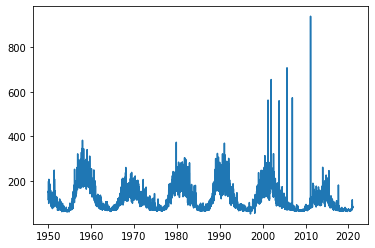

In [70]:
# get archive data and preprocess

# read in data
dataobj = cESA_SWE(verb=True)
data_arc = dataobj.fget_data(filenames=config.data_fnames)
df = data_arc[config.data_var]
df.set_index('ds', inplace=True)

# take subset of data
df_lim = df[config.date_llim:config.date_ulim]

# get daily values
df_daily = dataobj.fget_daily(df_lim, config.get_daily_method)

# account for missing data
dfa_esa = dataobj.fmissing_data(df_daily, config.missing_data_method)
dataobj.fcheck_missing(dfa_esa)

# plot
fig, ax = plt.subplots()
ax.plot(dfa_esa)
plt.show()

In [56]:
def fget_data(config, plot=False):
    """
    Read in data from file
    Assume format as in ESA Space Weather Database
    """
    # read in data
    dataobj = cESA_SWE()
    data_arc = dataobj.fget_data(filenames=config.data_fnames)
    df = data_arc[config.data_var]
    
    df.set_index('ds', inplace=True)
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(df)
        plt.show()

    # take subset of data
    df_lim = df[config.date_llim:config.date_ulim]
    
    # interpolate
    df_interp = dataobj.finterpolate(df_lim, config.interp_freq)
    
    return df_interp

In [57]:
# again need to be careful that upper limit of data is 30 days ahead of available forecast else will have to drop later
dfa_esa = fget_data(config)
dfa_esa

,y
ds,
1950-01-01,152.000000
1950-01-02,153.500000
1950-01-03,155.000000
1950-01-04,151.666667
1950-01-05,148.333333
...,...
2020-12-28,87.270000
2020-12-29,86.660000
2020-12-30,84.490000


In [76]:
dataobj = cESA_SWE()

In [77]:
data_for = dataobj.fget_data(filenames=config.forecast_fnames)
dff_esa = data_for["F107_NMH_esforc"]
dff_esa

,gendate,ds,y
0,2016-11-26,2016-11-26,82
1,2016-11-26,2016-11-27,84
2,2016-11-26,2016-11-28,84
3,2016-11-26,2016-11-29,84
4,2016-11-26,2016-11-30,84
...,...,...,...
40063,2021-01-18,2021-02-09,79
40064,2021-01-18,2021-02-10,79
40065,2021-01-18,2021-02-11,80
40066,2021-01-18,2021-02-12,81


In [78]:
# generate table with nbeats and esa forecast at comparable timesteps
dff_comp_esa = dataobj.fget_forecast_comp(dff_esa, dfa_esa, cname="y")
dff_comp_esa

,gendate,ds,y,y_true
0,2016-11-26,2016-11-26,82,81.2
1,2016-11-26,2016-11-27,84,82.6
2,2016-11-26,2016-11-28,84,85.2
3,2016-11-26,2016-11-29,84,85.5
4,2016-11-26,2016-11-30,84,83.6
...,...,...,...,...
39226,2020-12-29,2020-12-30,87,82.8
39227,2020-12-29,2020-12-31,88,81.2
39228,2020-12-30,2020-12-30,84,82.8
39229,2020-12-30,2020-12-31,84,81.2


In [79]:
dff_comp_esa[dff_comp_esa.ds == "2017-01-05"]

,gendate,ds,y,y_true
404,2016-12-10,2017-01-05,78,73.3
430,2016-12-11,2017-01-05,78,73.3
455,2016-12-13,2017-01-05,78,73.3
480,2016-12-15,2017-01-05,78,73.3
506,2016-12-16,2017-01-05,78,73.3
532,2016-12-17,2017-01-05,78,73.3
558,2016-12-18,2017-01-05,77,73.3
584,2016-12-19,2017-01-05,77,73.3
610,2016-12-20,2017-01-05,77,73.3
636,2016-12-21,2017-01-05,77,73.3


In [80]:
dataobj.fget_persistence(dff_comp_esa, 'y_true', "persistence_esa")

,gendate,ds,y,y_true,persistence_esa
0,2016-11-26,2016-11-26,82,81.2,NaN
1,2016-11-26,2016-11-27,84,82.6,NaN
2,2016-11-26,2016-11-28,84,85.2,NaN
3,2016-11-26,2016-11-29,84,85.5,NaN
4,2016-11-26,2016-11-30,84,83.6,NaN
...,...,...,...,...,...
39226,2020-12-29,2020-12-30,87,82.8,87.2
39227,2020-12-29,2020-12-31,88,81.2,87.2
39228,2020-12-30,2020-12-30,84,82.8,84.2
39229,2020-12-30,2020-12-31,84,81.2,84.2


## ESA SOLMAG

## Combine tables

In [89]:
df1 = dff_comp_esa
df2 = dff_comp_cls

In [127]:
# compare esa vs cls archival data
t = dfa_cls.sample(1).index.values[0]
t, dfa_esa.loc[t].y, dfa_cls.loc[t]["f10.7"] #dfa_cls[dfa_cls.ds == t]["f10.7"].values 

(numpy.datetime64('2018-10-17T00:00:00.000000000'), 70.0, 71.8)

In [99]:
# join esa and cls tables together
df3 = pd.merge(df1, df2, on=['gendate', 'ds'])
df3

,gendate,ds,y,y_true,persistence_esa,y_cls,y_cls_true,persistence_cls
0,2016-12-30,2016-12-30,74,73.6,73.4,71.9,73.7,NaN
1,2016-12-30,2016-12-31,75,73.5,73.4,72.0,73.6,NaN
2,2016-12-30,2017-01-01,75,72.5,73.4,72.1,72.6,NaN
3,2016-12-30,2017-01-02,75,73.0,73.4,72.3,73.1,NaN
4,2016-12-30,2017-01-03,75,73.4,73.4,72.4,73.5,NaN
...,...,...,...,...,...,...,...,...
38362,2020-12-29,2020-12-30,87,82.8,87.2,86.0,83.0,87.0
38363,2020-12-29,2020-12-31,88,81.2,87.2,85.6,81.0,87.0
38364,2020-12-30,2020-12-30,84,82.8,84.2,82.7,83.0,84.0
38365,2020-12-30,2020-12-31,84,81.2,84.2,82.2,81.0,84.0


In [100]:
df3[df3.ds == "2017-01-05"]

,gendate,ds,y,y_true,persistence_esa,y_cls,y_cls_true,persistence_cls
6,2016-12-30,2017-01-05,76,73.3,73.4,72.8,73.4,NaN
32,2016-12-31,2017-01-05,76,73.3,73.6,73.3,73.4,73.7
58,2017-01-01,2017-01-05,75,73.3,73.5,73.9,73.4,73.6
84,2017-01-02,2017-01-05,74,73.3,72.5,73.2,73.4,72.6
109,2017-01-04,2017-01-05,74,73.3,73.0,72.2,73.4,73.5
135,2017-01-05,2017-01-05,72,73.3,72.4,71.0,73.4,72.5


In [101]:
df3

,gendate,ds,y,y_true,persistence_esa,y_cls,y_cls_true,persistence_cls
0,2016-12-30,2016-12-30,74,73.6,73.4,71.9,73.7,NaN
1,2016-12-30,2016-12-31,75,73.5,73.4,72.0,73.6,NaN
2,2016-12-30,2017-01-01,75,72.5,73.4,72.1,72.6,NaN
3,2016-12-30,2017-01-02,75,73.0,73.4,72.3,73.1,NaN
4,2016-12-30,2017-01-03,75,73.4,73.4,72.4,73.5,NaN
...,...,...,...,...,...,...,...,...
38362,2020-12-29,2020-12-30,87,82.8,87.2,86.0,83.0,87.0
38363,2020-12-29,2020-12-31,88,81.2,87.2,85.6,81.0,87.0
38364,2020-12-30,2020-12-30,84,82.8,84.2,82.7,83.0,84.0
38365,2020-12-30,2020-12-31,84,81.2,84.2,82.2,81.0,84.0


## add persistence and averages as baseline

In [102]:
df4 = dataobj.fget_persistence(df3, "y_true")
df4[-10:]

,gendate,ds,y,y_true,persistence_esa,y_cls,y_cls_true,persistence_cls,persistence
38357,2020-12-28,2020-12-28,88,87.2,87.8,87.8,87.0,88.0,87.8
38358,2020-12-28,2020-12-29,89,84.2,87.8,87.4,84.0,88.0,87.8
38359,2020-12-28,2020-12-30,89,82.8,87.8,87.1,83.0,88.0,87.8
38360,2020-12-28,2020-12-31,89,81.2,87.8,86.5,81.0,88.0,87.8
38361,2020-12-29,2020-12-29,88,84.2,87.2,86.4,84.0,87.0,87.2
38362,2020-12-29,2020-12-30,87,82.8,87.2,86.0,83.0,87.0,87.2
38363,2020-12-29,2020-12-31,88,81.2,87.2,85.6,81.0,87.0,87.2
38364,2020-12-30,2020-12-30,84,82.8,84.2,82.7,83.0,84.0,84.2
38365,2020-12-30,2020-12-31,84,81.2,84.2,82.2,81.0,84.0,84.2
38366,2020-12-31,2020-12-31,83,81.2,82.8,81.4,81.0,83.0,82.8


## Get external forecasts

In [ ]:
user_config = {
        
    # data
    "data_src"            : "esa",                      # use esa archive data to learn from (to be implemented + other options)
    "data_comp"           : ["esa", "cls", "usaf"],     # external forecasts to compare to ["esa", "cls"]
    "date_llim"           : "1950-01-01",       # lower date cut for data for training/testing
    "date_ulim"           : "2021-01-01",       # upper date cut for data for training/testing
    "interp_freq"         : 24,                 # interpolation frequency [HOURS] (to ensure regularly spaced data)
    
    # esa data
    "esa_archive_fname"  : "data/f107_2016_11/archive_f107.txt",  # esa archived data to learn from
    "esa_forecast_fname" : "data/f107_2016_11/forecast_bgs.txt",  # esa forecast data to compare to
    "esa_archive_key"    : "f10_7",                                       # key for datadict of filenames
    "esa_forecast_key"   : "F107_NMH_esforc",                             # key for datadict of filenames
    
    # cls-cnes data
    "cls_datadir"        : "data/clstest",           # directory where data is downloaded to
    "cls_key"            : "f10.7",                  # key for column header
    "cls_forecast_ldate" : "2016-06-01",             # lower date to download cls from for forecast files "2017-01-01"
    "cls_forecast_udate" : "2020-06-01",             # upper date to download cls to for forecast files
    "cls_adj"            : False,                    # adjusted data?
    
    # other forecasts from esa swe portal
    "swpc_forecast_fname"  : "data/f107_2016_11/forecast_swpc.txt",  # NOAA SWPC 27 day
    "swpc_forecast_key"    : "F107_SWPC_forecast_27DO",
    "usaf_forecast_fname"  : "data/f107_2016_11/forecast_usaf.txt",  # NOAA USAF 45 day
    "usaf_forecast_key"    : "F107_SWPC_forecast_45DF"
}

In [ ]:
# read in config
config = AttrDict()
config.update(user_config)

In [ ]:
df_merged = fget_external_forecasts(config)